In [1]:
# First, install the Hugging Face datasets library
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 30.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
# Import the library
from datasets import load_dataset

# Load the dataset
#data = load_dataset('chloeliu/lyrics')
data = load_dataset('chloeliu/lyrics')
# Now, you can use the dataset in your notebook
print(data)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/28372 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'artist_name', 'track_name', 'release_date', 'genre', 'lyrics', 'len', 'dating', 'violence', 'world/life', 'night/time', 'shake the audience', 'family/gospel', 'romantic', 'communication', 'obscene', 'music', 'movement/places', 'light/visual perceptions', 'family/spiritual', 'like/girls', 'sadness', 'feelings', 'danceability', 'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy', 'topic', 'age'],
        num_rows: 28372
    })
})


In [3]:
# Import necessary libraries
import random
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm  # Import tqdm
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load the dataset
data = load_dataset("amzar1303/lyrics")

# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set padding token if it's not already set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Preprocess the dataset
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=128, padding='max_length')

# Apply the preprocess function to the dataset
dataset = data.map(preprocess_function, batched=True)

# Select 5,000 random samples
random_indices = random.sample(range(len(dataset['train'])), k=4000)
dataset['train'] = dataset['train'].select(random_indices)

# Prepare the dataset for training
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

# Create a DataLoader
dataloader = DataLoader(dataset['train'], batch_size=1, shuffle=True)

# Initialize the model
#model = GPT2LMHeadModel.from_pretrained('gpt2')






Generating train split:   0%|          | 0/4529 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/4529 [00:00<?, ? examples/s]

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.cuda.amp import autocast, GradScaler

def perplexity(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_batches = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['input_ids'].to(device)

            # Forward pass
            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            total_loss += loss.item()
            total_batches += 1

    avg_loss = total_loss / total_batches
    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity

def fine_tune_model(model, dataloader, device, learning_rate=0.001, num_epochs=1, batch_size=32):  # Added batch_size parameter
    # Convert DataLoader to list of samples
    samples = []
    for batch in dataloader:
        samples.append(batch)
    # Split the dataset into train and validation sets (80% train, 20% validation)
    train_samples, val_samples = train_test_split(samples, test_size=0.2, random_state=42)
    train_loader = torch.utils.data.DataLoader(train_samples, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_samples, batch_size=batch_size)

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Move the model to the GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Initialize a list to hold the losses
    train_losses = []
    val_perplexities = []

    # Training loop
    model.train()
    scaler = GradScaler()
    for epoch in range(num_epochs):
        # Train the model
        epoch_train_loss = 0.0
        num_train_batches = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}, LR {learning_rate}", unit="batch", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Forward pass
            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
                loss = outputs.loss

            # Backward pass
            scaler.scale(loss).backward()

            # Update the weights
            scaler.step(optimizer)

            # Clear the gradients
            optimizer.zero_grad()
            scaler.update()

            # Accumulate the loss
            epoch_train_loss += loss.item()
            num_train_batches += 1

        # Record the average training loss for this epoch
        train_loss = epoch_train_loss / num_train_batches
        train_losses.append(train_loss)

        # Evaluate the model on validation set
        val_perplexity = perplexity(model, val_loader, device)
        val_perplexities.append(val_perplexity)

        # Print training and validation losses
        print(f"Epoch {epoch+1}: Train Loss: {train_loss}, Val Perplexity: {val_perplexity}")

    # Plot the loss curve
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

    # Plot the perplexity curve
    plt.plot(val_perplexities, label='Val Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Validation Perplexity')
    plt.legend()
    plt.show()

    # Save the model
    model.save_pretrained('./content/models')

    return model


Epoch 1: Train Loss: 4.608654851913452, Val Perplexity: 65.86701965332031


Epoch 2: Train Loss: 3.98536230802536, Val Perplexity: 48.802223205566406


Epoch 3: Train Loss: 3.751905119419098, Val Perplexity: 42.19845962524414


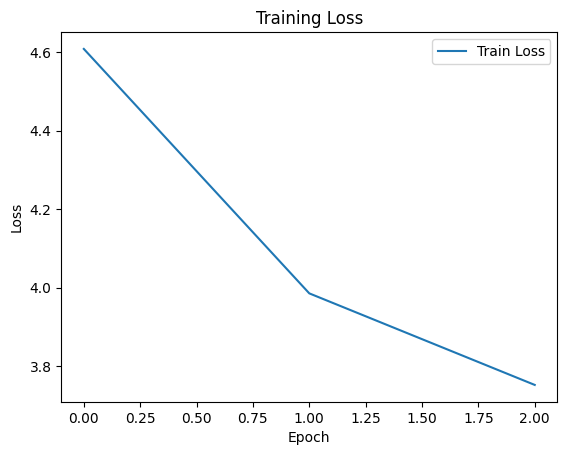

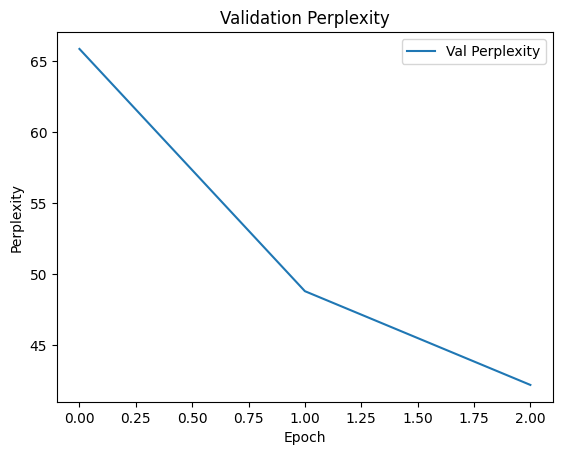

In [12]:
# Fine-tune the model
# Initialize the model
model_GPT = GPT2LMHeadModel.from_pretrained('gpt2')

model_GPT = fine_tune_model(model_GPT, dataloader, device, learning_rate=0.00001, num_epochs=3, batch_size=32)

In [13]:
# Set the model in evaluation mode
model_GPT.eval()

# Lyrics generation function
def generate_lyrics(prompt):
    # Encode the prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Generate text
    output = model_GPT.generate(input_ids, max_length=100, temperature=0.9, do_sample=True, pad_token_id=tokenizer.eos_token_id)

    # Decode the output
    lyrics = tokenizer.decode(output[:, input_ids.shape[-1]:][0], skip_special_tokens=True)

    return lyrics

# Use the function to generate lyrics
prompt = "Talking away I don't know what I'm to say I'll say it anyway today's another day to find you Shying away I'll be coming for you love O.K."
print("Prompt: ", prompt)
print("Next Lyrics: ")
print(generate_lyrics(prompt))

Prompt:  Talking away I don't know what I'm to say I'll say it anyway today's another day to find you Shying away I'll be coming for you love O.K.
Next Lyrics: 
  I guess you could say you loved me tonight I think it's too late I'm too scared to say anything But I know you can always find love I know you will always find love I'm too young to be alone I feel a new world  I think I'm alone now But I don't know what


In [9]:
import random
from transformers import GPT2Tokenizer
from torch.utils.data import DataLoader
from datasets import load_dataset

def create_dataloader(tokenizer, batch_size=1):
    # Load the dataset
    data = load_dataset("amzar1303/lyrics")

    # Set padding token if it's not already set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Preprocess the dataset
    def preprocess_function(examples):
        return tokenizer(examples['text'], truncation=True, max_length=128, padding='max_length')

    # Apply the preprocess function to the dataset
    dataset = data.map(preprocess_function, batched=True)

    # Select 5,000 random samples
    random_indices = random.sample(range(len(dataset['train'])), k=4000)
    dataset['train'] = dataset['train'].select(random_indices)

    # Prepare the dataset for training
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

    # Create a DataLoader
    dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)

    return dataloader


XLNET

In [10]:
from transformers import BartForConditionalGeneration, BartTokenizer

# Initialize BART model and tokenizer
model_BART = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
tokenizer_BART = BartTokenizer.from_pretrained('facebook/bart-base')
dataloader_BART = create_dataloader(tokenizer_BART, batch_size=1)

# Fine-tune the model
# Use the same fine_tune_model function as before



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/4529 [00:00<?, ? examples/s]

In [11]:
model_BART = fine_tune_model(model_BART, dataloader_BART, device, learning_rate=0.001, num_epochs=3)

ValueError: too many values to unpack (expected 2)

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Initialize T5 model and tokenizer
model_T5 = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer_T5 = T5Tokenizer.from_pretrained('t5-small')

# Fine-tune the model
# Use the same fine_tune_model function as before
model_T5 = fine_tune_model(model_T5, dataloader, device, learning_rate=0.001, num_epochs=3)


In [ ]:
from transformers import XLNetLMHeadModel, XLNetTokenizer

# Initialize XLNet model and tokenizer
model_XLNet = XLNetLMHeadModel.from_pretrained('xlnet-base-cased')
tokenizer_XLNet = XLNetTokenizer.from_pretrained('xlnet-base-cased')

# Fine-tune the model
# Use the same fine_tune_model function as before
model_XLNet = fine_tune_model(model_XLNet, dataloader, device, learning_rate=0.001, num_epochs=3)
